In [0]:
!pip install pmdarima

In [1]:
import os
os.getcwd()

'/content'

In [0]:
import numpy as np
import pandas as pd 
import numpy as np
#import matplotlib
%matplotlib inline
# Load specific forecasting tools
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.arima_model import ARMA,ARMAResults,ARIMA,ARIMAResults
# from statsmodels.graphics.tsaplots import plot_acf,plot_pacf # for determining (p,q) orders
from pmdarima import auto_arima # for determining ARIMA orders
import warnings
warnings.filterwarnings('ignore')

In [0]:
from statsmodels.tsa.stattools import adfuller

def adf_test(series,title=''):
    """
    Pass in a time series and an optional title, returns an ADF report
    """
    print(f'Augmented Dickey-Fuller Test: {title}')
    result = adfuller(series.dropna(),autolag='AIC') # .dropna() handles differenced data
    
    labels = ['ADF test statistic','p-value','# lags used','# observations']
    out = pd.Series(result[0:4],index=labels)

    for key,val in result[4].items():
        out[f'critical value ({key})']=val
        
    print(out.to_string())          # .to_string() removes the line "dtype: float64"
    
    if result[1] <= 0.05:
        print("Strong evidence against the null hypothesis")
        print("Reject the null hypothesis")
        print("Data has no unit root and is stationary")
    else:
        print("Weak evidence against the null hypothesis")
        print("Fail to reject the null hypothesis")
        print("Data has a unit root and is non-stationary")

In [0]:
#option1: births
df1=pd.read_csv('DailyTotalFemaleBirths.csv',index_col='Date',parse_dates=True)
df1.index.freq='D'

In [0]:
#option2: deaths
df1=pd.read_csv('covid.csv', parse_dates=True)
df1 = df1.rename(columns={'Date reported': 'date', 'Case status': 'deaths'})
#df1.index.freq='D'
df1=df1.groupby(["date"]).count()

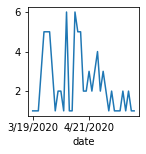

In [113]:
# df1['Births'].plot(figsize=(2,2)) 
df1['deaths'].plot(figsize=(2,2)) 

In [123]:
# adf_test(df1['Births'])
adf_test(df1['deaths'])

Augmented Dickey-Fuller Test: 
ADF test statistic      -4.090101
p-value                  0.001006
# lags used              0.000000
# observations          36.000000
critical value (1%)     -3.626652
critical value (5%)     -2.945951
critical value (10%)    -2.611671
Strong evidence against the null hypothesis
Reject the null hypothesis
Data has no unit root and is stationary


In [156]:
# auto_arima(df1['Births'], seasonal=True).summary()
auto_arima(df1['deaths'], seasonal=True, D=7).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Statespace Model Results                           
==============================================================================
Dep. Variable:                      y   No. Observations:                   37
Model:               SARIMAX(1, 0, 1)   Log Likelihood                 -65.842
Date:                Mon, 18 May 2020   AIC                            139.685
Time:                        23:36:15   BIC                            146.129
Sample:                             0   HQIC                           141.957
                                 - 37                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      3.7811      0.939      4.026      0.000       1.940       5.622
ar.L1         -0.5467      0.193     -2.831      0.005      -0.925      -0.168
ma.L1          0.9997     28.381      0.035      0.972     -54.625      56.625
sigma2         1.9244     54.404      0.035      0.972    -104.706     108.555
===================================================================================
Ljung-Box (Q):                         nan   Jarque-Bera (JB):                 1.68
Prob(Q):                               nan   Prob(JB):                         0.43
Heteroskedasticity (H):               0.67   Skew:                             0.52
Prob(H) (two-sided):                  0.49   Kurtosis:                         3.06
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [0]:
# train = df1.iloc[:90]
# test = df1.iloc[90:]
train=df1.iloc[:28]
test=df1.iloc[28:]

In [126]:
#results=ARIMA(train['Births'],order=(1,1,1)).fit()
# ARIMA(train['Births'],order=(1,1,1)).fit().summary()
results=ARIMA(train['deaths'],order=(1,0,1)).fit() #results for train data
ARIMA(train['deaths'],order=(1,0,1)).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:                 deaths   No. Observations:                   28
Model:                     ARMA(1, 1)   Log Likelihood                 -51.142
Method:                       css-mle   S.D. of innovations              1.445
Date:                Mon, 18 May 2020   AIC                            110.285
Time:                        21:43:49   BIC                            115.614
Sample:                             0   HQIC                           111.914
                                                                              
================================================================================
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
const            2.7857      0.349      7.971      0.000       2.101       3.471
ar.L1.deaths    -0.5561      0.165     -3.368      0.002      -0.880      -0.233
ma.L1.deaths     1.0000      0.126      7.951      0.000       0.753       1.246
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1           -1.7982           +0.0000j            1.7982            0.5000
MA.1           -1.0000           +0.0000j            1.0000            0.5000
-----------------------------------------------------------------------------
"""

In [0]:
start=len(train)
end=len(train)+len(test)-1

In [0]:
predictions=results.predict(start, end).rename('ARMA(1,1) Predictions') 

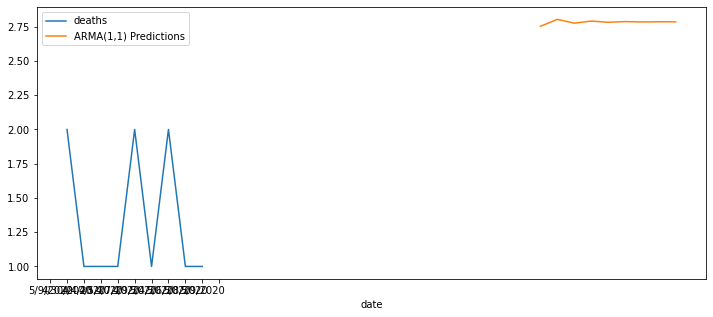

In [130]:
# test['Births'].plot(figsize=(3,3), legend=True)
test['deaths'].plot(figsize=(12,5), legend=True)
predictions.plot(legend=True)

In [155]:
test.mean()
predictions.mean()

2.783374568092632

In [136]:
from statsmodels.tools.eval_measures import rmse
rmse(test['deaths'], predictions)

1.5269507697691191

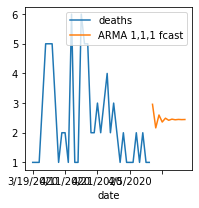

In [153]:
model_f=ARMA(df1['deaths'],order=(1,1)) #model for all the data
results_f=model_f.fit()
start_f=len(df1)
end_f=len(df1)+10
fcast = results_f.predict(start_f, end_f).rename('ARMA 1,1,1 fcast')
df1['deaths'].plot(legend=True, figsize=(3,3))
fcast.plot(legend=True)

#ARIMA, Seasonal Decompose & Diff

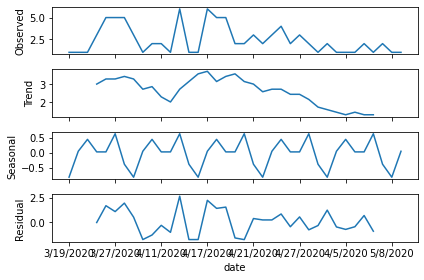

In [144]:
#from statsmodels.tsa.seasonal import seasonal_decompose
#seasonal_decompose(df2['Inventories'],model='add').plot();
#covid:
seasonal_decompose(df1['deaths'], freq=7).plot();


In [49]:
from statsmodels.tsa.statespace.tools import diff
df1['diff1']=diff(df1['deaths'], k_diff=1)
adf_test(df1['diff1'])

Augmented Dickey-Fuller Test: 
ADF test statistic      -4.960116
p-value                  0.000027
# lags used              3.000000
# observations          32.000000
critical value (1%)     -3.653520
critical value (5%)     -2.957219
critical value (10%)    -2.617588
Strong evidence against the null hypothesis
Reject the null hypothesis
Data has no unit root and is stationary
